In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
#Importing the basic librarires

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D , MaxPool2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation, Flatten , BatchNormalization

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
#Filtro imagenes corruptas

import os

num_skipped = 0
for folder_name in ("Healthy", "Unhealthy"):
    folder_path = os.path.join("Plants_ds", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [6]:
#Generación del dataset

image_size = (224, 224)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "Plants_ds",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1821 files belonging to 2 classes.
Using 1457 files for training.
Using 364 files for validation.


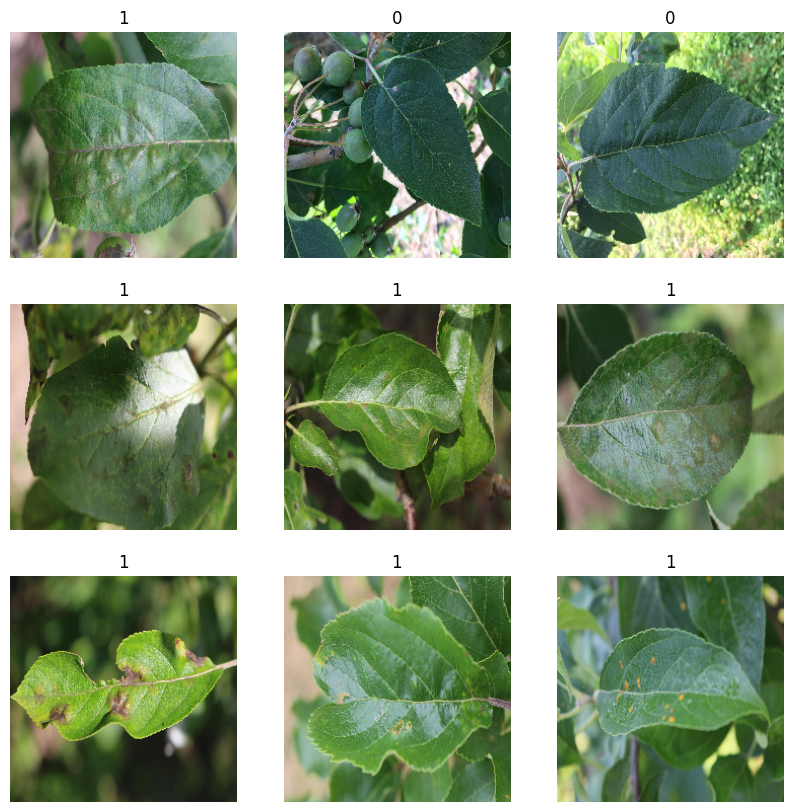

In [8]:
#1 es unhealthy, 0 es healthy

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [9]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
#Train the model

epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
              train_ds,
              epochs=epochs,
              callbacks=callbacks,
              validation_data=val_ds,
          )

Epoch 1/25
46/46 [==============================] - 18s 335ms/step - loss: 0.5601 - accuracy: 0.7378 - val_loss: 0.6247 - val_accuracy: 0.7005
Epoch 2/25
46/46 [==============================] - 16s 331ms/step - loss: 0.5517 - accuracy: 0.7454 - val_loss: 0.6439 - val_accuracy: 0.7005
Epoch 3/25
46/46 [==============================] - 16s 331ms/step - loss: 0.5099 - accuracy: 0.7536 - val_loss: 0.6816 - val_accuracy: 0.6593
Epoch 4/25
46/46 [==============================] - 16s 330ms/step - loss: 0.3861 - accuracy: 0.8106 - val_loss: 0.8671 - val_accuracy: 0.2995
Epoch 5/25
46/46 [==============================] - 16s 333ms/step - loss: 0.2826 - accuracy: 0.8751 - val_loss: 1.1596 - val_accuracy: 0.2995
Epoch 6/25
46/46 [==============================] - 16s 332ms/step - loss: 0.2032 - accuracy: 0.9149 - val_loss: 1.3611 - val_accuracy: 0.3159
Epoch 7/25
46/46 [==============================] - 16s 336ms/step - loss: 0.1622 - accuracy: 0.9382 - val_loss: 0.5747 - val_accuracy: 0.6484